### Import Libraries

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import xgboost as xgb
import joblib
from sklearn.preprocessing import StandardScaler


### Load Dataset

In [2]:
df = pd.read_csv("../data/UNSW_NB15_training-set.csv")
print("Shape:", df.shape)
df.head()

Shape: (82332, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


### Preprocess Dataset

In [3]:
# Drop unneeded columns
drop_cols = ['id', 'label', 'attack_cat']  # keep 'label' separately
features = df.drop(columns=drop_cols)

# Target variable
target = df['label']

# Encode any categorical columns (like 'proto', 'state', 'service')
cat_cols = features.select_dtypes(include='object').columns
features[cat_cols] = features[cat_cols].apply(LabelEncoder().fit_transform)


### Train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)


### Train XGBoost Classifier

In [5]:
model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)


C:\Users\princ\OneDrive\Pictures\Documents\ai-threat-detection-cybersecurity\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:42:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


### Evaluate model 

Accuracy: 0.9740086233072205

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      7418
           1       0.98      0.97      0.98      9049

    accuracy                           0.97     16467
   macro avg       0.97      0.97      0.97     16467
weighted avg       0.97      0.97      0.97     16467



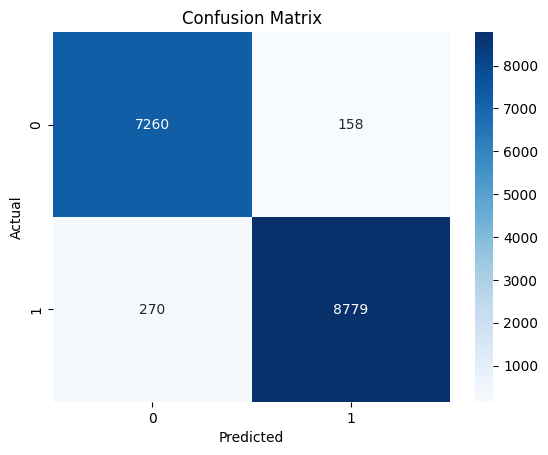

In [6]:
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("../reports/visualizations/confusion_matrix.png")
plt.show()


### Feature Importance

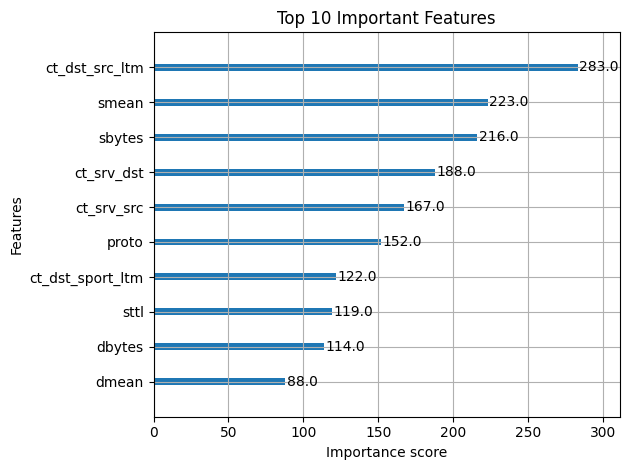

In [7]:
xgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Important Features")
plt.tight_layout()
plt.savefig("../reports/visualizations/feature_importance.png")
plt.show()


### Save Model

In [8]:
joblib.dump(model, "../model/xgboost_classifier.pkl")
print("✅ Model saved to model/xgboost_classifier.pkl")

✅ Model saved to model/xgboost_classifier.pkl


### Save Evaluation report

In [9]:
report = classification_report(y_val, y_pred, output_dict=True)
pd.DataFrame(report).transpose().to_csv("../reports/classification_report.csv")

with open("../reports/evaluation_metrics.txt", "w") as f:
    f.write(f"Accuracy: {accuracy_score(y_val, y_pred)}\n")


In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)

# Save the scaler
joblib.dump(scaler, "../model/scaler.pkl")


['../model/scaler.pkl']

## Dual Model Training: Attack Detection and Attack Category Classification
This section trains two models:
- Model 1: Binary classification (attack/benign) using the 'label' column.
- Model 2: Multi-class classification (attack type) using the 'attack_cat' column, only on attack rows.

In [12]:
# Prepare features (drop id, label, attack_cat)
feature_cols = [col for col in df.columns if col not in ['id', 'label', 'attack_cat']]
features = df[feature_cols].copy()

# Encode categorical columns
cat_cols = features.select_dtypes(include='object').columns
for col in cat_cols:
    features[col] = LabelEncoder().fit_transform(features[col].astype(str))

# -------------------
# Model 1: Binary Classification (Attack/Benign)
# -------------------
X = features.copy()
y = df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train binary classifier
binary_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')
binary_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = binary_model.predict(X_val_scaled)
print("[Binary] Accuracy:", accuracy_score(y_val, y_pred))
print("\n[Binary] Classification Report:\n", classification_report(y_val, y_pred))

# Save binary model and scaler
joblib.dump(binary_model, "../model/xgboost_classifier.pkl")
joblib.dump(scaler, "../model/scaler.pkl")
print("✅ Binary model and scaler saved.")

C:\Users\princ\OneDrive\Pictures\Documents\ai-threat-detection-cybersecurity\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:42:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[Binary] Accuracy: 0.9739478957915831

[Binary] Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      7418
           1       0.98      0.97      0.98      9049

    accuracy                           0.97     16467
   macro avg       0.97      0.97      0.97     16467
weighted avg       0.97      0.97      0.97     16467

✅ Binary model and scaler saved.


In [13]:
# -------------------
# Model 2: Multi-class Classification (Attack Category)
# -------------------
attack_rows = df[df['label'] == 1].copy()
attack_features = attack_rows[feature_cols].copy()
attack_target = attack_rows['attack_cat']

# Encode categorical columns (again, for attack subset)
for col in attack_features.select_dtypes(include='object').columns:
    attack_features[col] = LabelEncoder().fit_transform(attack_features[col].astype(str))

# Encode attack_cat target
attack_cat_encoder = LabelEncoder()
attack_target_encoded = attack_cat_encoder.fit_transform(attack_target)

# Use the same scaler as before
attack_features_scaled = scaler.transform(attack_features)

X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(attack_features_scaled, attack_target_encoded, test_size=0.2, random_state=42)

# Train multi-class classifier
attack_cat_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
attack_cat_model.fit(X_train_a, y_train_a)

# Evaluate
y_pred_a = attack_cat_model.predict(X_val_a)
print("[AttackCat] Accuracy:", accuracy_score(y_val_a, y_pred_a))
print("\n[AttackCat] Classification Report:\n", classification_report(y_val_a, y_pred_a, target_names=attack_cat_encoder.classes_))

# Save attack category model and encoder
joblib.dump(attack_cat_model, "../model/xgboost_attack_cat.pkl")
joblib.dump(attack_cat_encoder, "../model/attack_cat_encoder.pkl")
print("✅ Attack category model and encoder saved.")

C:\Users\princ\OneDrive\Pictures\Documents\ai-threat-detection-cybersecurity\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:42:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[AttackCat] Accuracy: 0.8257417006727694

[AttackCat] Classification Report:
                 precision    recall  f1-score   support

      Analysis       1.00      0.09      0.17       140
      Backdoor       1.00      0.05      0.09       106
           DoS       0.48      0.58      0.53       862
      Exploits       0.71      0.75      0.73      2191
       Fuzzers       0.79      0.83      0.81      1238
       Generic       0.99      0.98      0.99      3780
Reconnaissance       0.92      0.80      0.86       673
     Shellcode       0.64      0.68      0.66        68
         Worms       1.00      0.33      0.50         9

      accuracy                           0.83      9067
     macro avg       0.84      0.57      0.59      9067
  weighted avg       0.84      0.83      0.82      9067

✅ Attack category model and encoder saved.


**Now you have two models:**
- `xgboost_classifier.pkl` for attack/benign prediction
- `xgboost_attack_cat.pkl` for attack type prediction (use only if attack is detected)
- `scaler.pkl` and `attack_cat_encoder.pkl` for preprocessing

## Hyperparameter Tuning for Best Score
Find the optimal number of boosting rounds for both models.

In [14]:
# -------------------
# Model 1: Binary Classification (Attack/Benign) WITHOUT Early Stopping
# -------------------
X = features.copy()
y = df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

binary_model = xgb.XGBClassifier(
    n_estimators=100,  # Fixed at 100, no early stopping
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

binary_model.fit(X_train_scaled, y_train)

y_pred = binary_model.predict(X_val_scaled)
print("[Binary] Accuracy:", accuracy_score(y_val, y_pred))
print("\n[Binary] Classification Report:\n", classification_report(y_val, y_pred))

joblib.dump(binary_model, "../model/xgboost_classifier.pkl")
joblib.dump(scaler, "../model/scaler.pkl")
print("✅ Binary model and scaler saved.")

# -------------------
# Model 2: Multi-class Classification (Attack Category) WITHOUT Early Stopping
# -------------------
attack_rows = df[df['label'] == 1].copy()
attack_features = attack_rows[feature_cols].copy()
attack_target = attack_rows['attack_cat']

for col in attack_features.select_dtypes(include='object').columns:
    attack_features[col] = LabelEncoder().fit_transform(attack_features[col].astype(str))

attack_cat_encoder = LabelEncoder()
attack_target_encoded = attack_cat_encoder.fit_transform(attack_target)

attack_features_scaled = scaler.transform(attack_features)

X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(
    attack_features_scaled, attack_target_encoded, test_size=0.2, random_state=42
)

attack_cat_model = xgb.XGBClassifier(
    n_estimators=100,  # Fixed at 100, no early stopping
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

attack_cat_model.fit(X_train_a, y_train_a)

y_pred_a = attack_cat_model.predict(X_val_a)
print("[AttackCat] Accuracy:", accuracy_score(y_val_a, y_pred_a))
print("\n[AttackCat] Classification Report:\n", classification_report(y_val_a, y_pred_a, target_names=attack_cat_encoder.classes_))

joblib.dump(attack_cat_model, "../model/xgboost_attack_cat.pkl")
joblib.dump(attack_cat_encoder, "../model/attack_cat_encoder.pkl")
print("✅ Attack category model and encoder saved.")

C:\Users\princ\OneDrive\Pictures\Documents\ai-threat-detection-cybersecurity\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:42:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[Binary] Accuracy: 0.9739478957915831

[Binary] Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      7418
           1       0.98      0.97      0.98      9049

    accuracy                           0.97     16467
   macro avg       0.97      0.97      0.97     16467
weighted avg       0.97      0.97      0.97     16467

✅ Binary model and scaler saved.


C:\Users\princ\OneDrive\Pictures\Documents\ai-threat-detection-cybersecurity\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:42:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[AttackCat] Accuracy: 0.8257417006727694

[AttackCat] Classification Report:
                 precision    recall  f1-score   support

      Analysis       1.00      0.09      0.17       140
      Backdoor       1.00      0.05      0.09       106
           DoS       0.48      0.58      0.53       862
      Exploits       0.71      0.75      0.73      2191
       Fuzzers       0.79      0.83      0.81      1238
       Generic       0.99      0.98      0.99      3780
Reconnaissance       0.92      0.80      0.86       673
     Shellcode       0.64      0.68      0.66        68
         Worms       1.00      0.33      0.50         9

      accuracy                           0.83      9067
     macro avg       0.84      0.57      0.59      9067
  weighted avg       0.84      0.83      0.82      9067

✅ Attack category model and encoder saved.


### Visualize Model Performance
Plot accuracy and confusion matrices for both the binary and multi-class models.

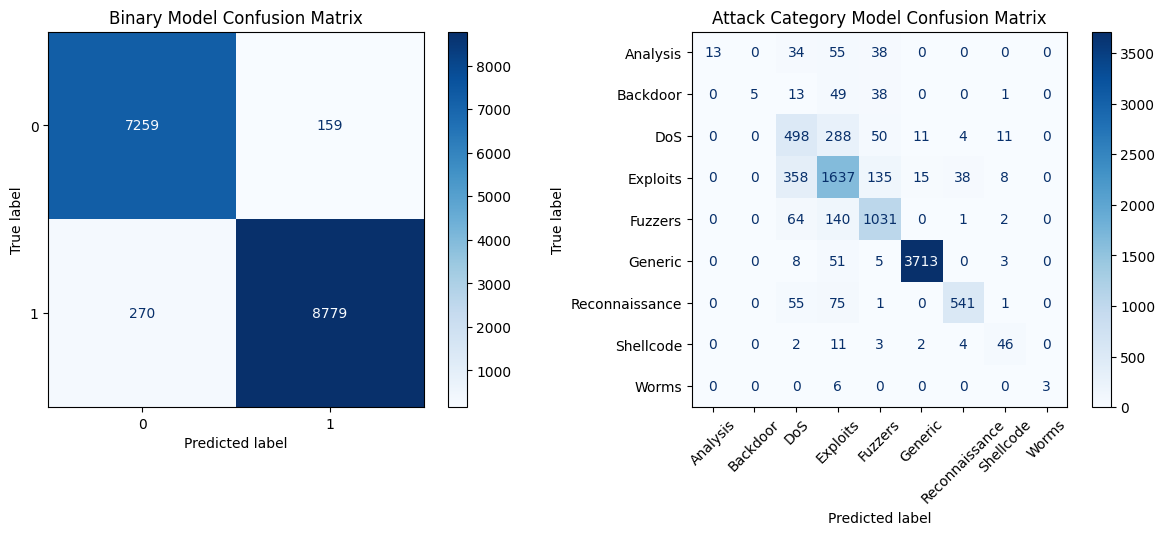

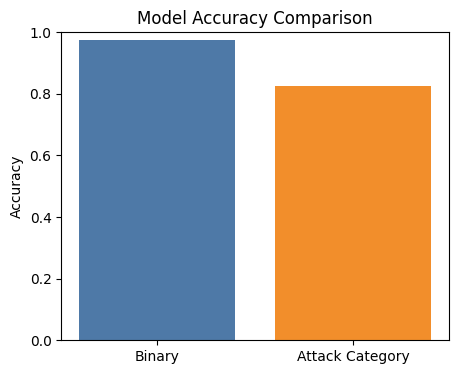

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

# Binary model performance
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Binary confusion matrix
ConfusionMatrixDisplay.from_estimator(binary_model, X_val_scaled, y_val, ax=ax[0], cmap='Blues')
ax[0].set_title('Binary Model Confusion Matrix')

# Multi-class confusion matrix (only for attack rows)
ConfusionMatrixDisplay.from_estimator(
    attack_cat_model, X_val_a, y_val_a, display_labels=attack_cat_encoder.classes_, ax=ax[1], cmap='Blues', xticks_rotation=45
)
ax[1].set_title('Attack Category Model Confusion Matrix')
plt.tight_layout()
plt.show()

# Plot accuracy for both models
binary_acc = accuracy_score(y_val, y_pred)
attack_cat_acc = accuracy_score(y_val_a, y_pred_a)

plt.figure(figsize=(5, 4))
plt.bar(['Binary', 'Attack Category'], [binary_acc, attack_cat_acc], color=['#4e79a7', '#f28e2b'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

### Elegant Visualizations of Model Performance
The following visualizations provide a clear and intuitive summary of both models' performance:
- Annotated confusion matrices with color gradients and percentage labels
- Side-by-side accuracy and per-class F1-score bar charts

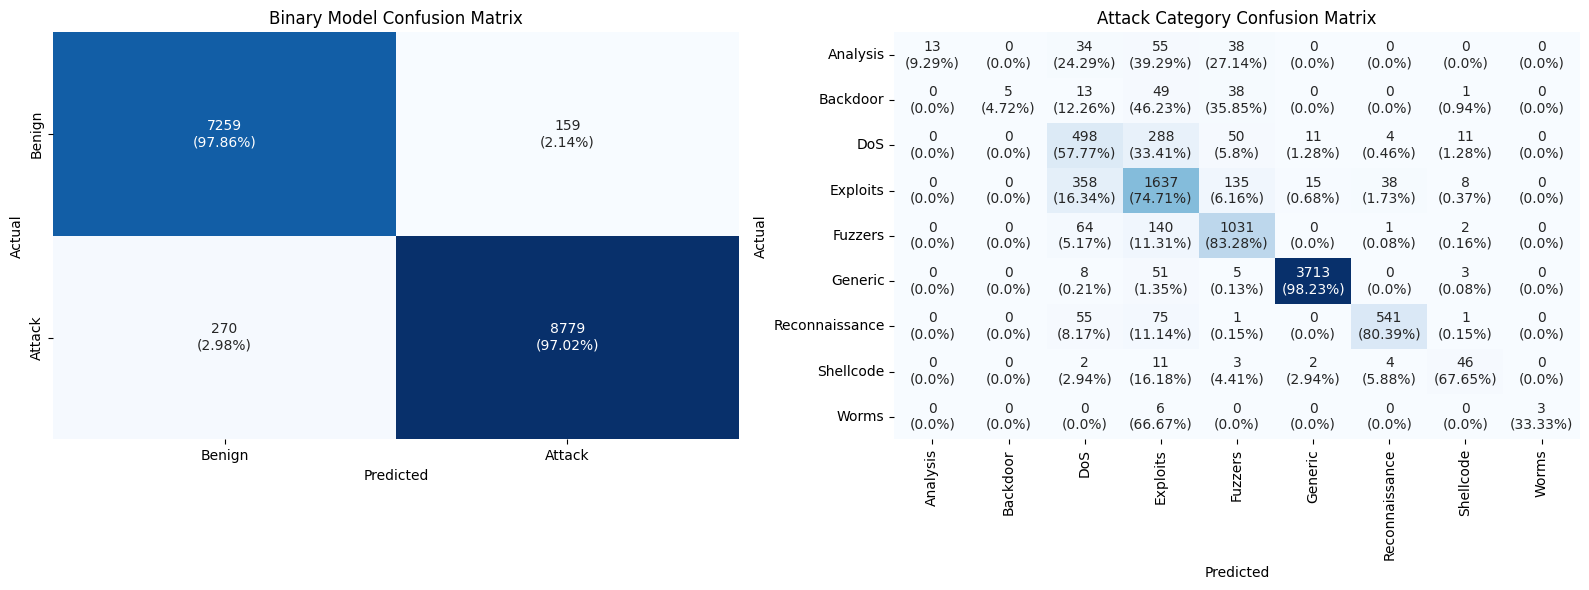

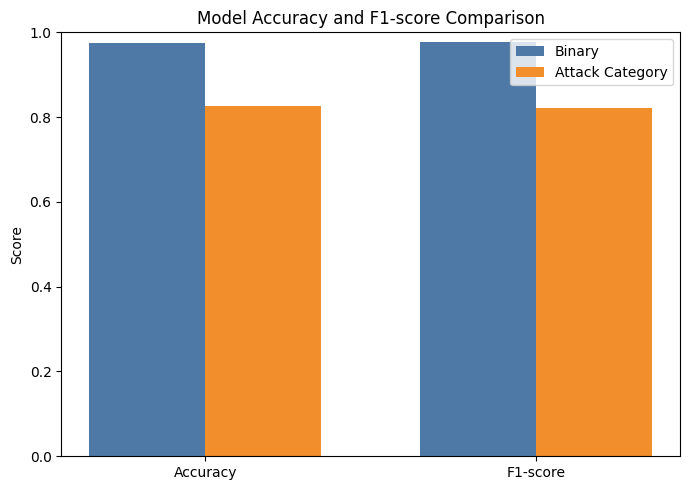

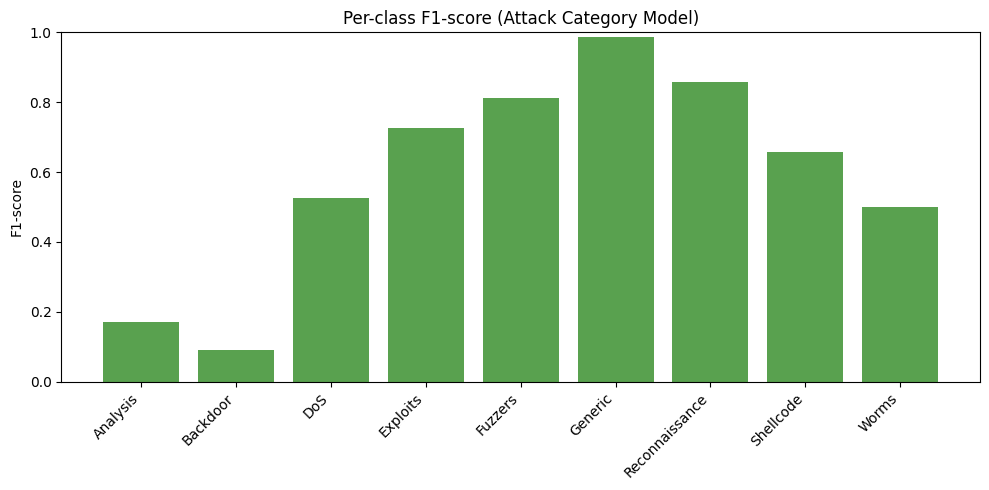

In [16]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

# --- Confusion Matrices with Percentages ---
def plot_confusion_matrix(cm, labels, title, ax):
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = np.round(cm / cm_sum.astype(float) * 100, 2)
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            s = f"{c}\n({p}%)"
            annot[i, j] = s
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax, cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Binary confusion matrix
cm_bin = confusion_matrix(y_val, y_pred)
plot_confusion_matrix(cm_bin, ['Benign', 'Attack'], 'Binary Model Confusion Matrix', axes[0])
# Multi-class confusion matrix
cm_multi = confusion_matrix(y_val_a, y_pred_a)
plot_confusion_matrix(cm_multi, attack_cat_encoder.classes_, 'Attack Category Confusion Matrix', axes[1])
plt.tight_layout()
plt.show()

# --- Accuracy and F1-score Bar Charts ---
from sklearn.metrics import f1_score
binary_f1 = f1_score(y_val, y_pred)
attack_cat_f1 = f1_score(y_val_a, y_pred_a, average='weighted')

plt.figure(figsize=(7, 5))
metrics = ['Accuracy', 'F1-score']
binary_scores = [accuracy_score(y_val, y_pred), binary_f1]
attack_cat_scores = [accuracy_score(y_val_a, y_pred_a), attack_cat_f1]
bar_width = 0.35
x = np.arange(len(metrics))
plt.bar(x - bar_width/2, binary_scores, bar_width, label='Binary', color='#4e79a7')
plt.bar(x + bar_width/2, attack_cat_scores, bar_width, label='Attack Category', color='#f28e2b')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Model Accuracy and F1-score Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# --- Per-class F1-score for Attack Category Model ---
per_class_f1 = f1_score(y_val_a, y_pred_a, average=None)
plt.figure(figsize=(10, 5))
plt.bar(attack_cat_encoder.classes_, per_class_f1, color='#59a14f')
plt.ylabel('F1-score')
plt.ylim(0, 1)
plt.title('Per-class F1-score (Attack Category Model)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()